In [220]:
# basic
import numpy as np
import pandas as pd
import pprint

# plot
#import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
import lightgbm as lgb

# optimization
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime
#import sys
#import gc

In [2]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [4]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [5]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [6]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

In [10]:
# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# Encoding

In [11]:
cat_cols = ['car name', 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

del cat_cols

# Create Model

In [14]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_X = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

#del train_test

In [16]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(X, y, args):
    args['max_depth'] = int(args['max_depth'])
    args['num_leaves'] = int(args['num_leaves'])
    args['min_data_in_leaf'] = int(args['min_data_in_leaf'])
    
    model = lgb.LGBMRegressor(**args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'score':make_scorer(RMSE)
    }
    
    scores = cross_validate(model, X=X, y=y, cv=kf, return_estimator=True, scoring=score_func)
    
    #history.append((model, scores))
    
    return {
        'loss':scores['test_score'].mean(),
        'status':STATUS_OK,
        'params':args
    }

In [264]:
# 変数候補すべてを最適化
param_space = {
    'alpha' : hp.loguniform(
        label='alpha', low=np.log(1e-8), high=np.log(1.0)
    ),
    'bagging_fraction': hp.quniform(
        label='bagging_fraction', low=0.6, high=0.95, q=0.05
    ),
    'feature_fraction': hp.quniform(
        label='feature_fraction', low=0.6, high=0.95, q=0.05
    ),
    'gamma': hp.quniform(
        label='gamma', low=0.1, high=0.4, q=0.1
    ),
    'lambda' : hp.loguniform(
        label='lambda', low=np.log(1e-6), high=np.log(10.0)
    ),
    'max_depth': hp.quniform(
        label='max_depth', low=3, high=9, q=1
    ),
    'min_child_weight': hp.quniform(
        label='min_child_weight', low=1, high=5, q=1
    ),
    'min_data_in_leaf': hp.quniform(
        label='min_data_in_leaf', low=5, high=20, q=2
    ),
    'num_leaves': hp.quniform(
        label='num_leaves', low=20, high=100, q=10
    )
}

#history = []

f = partial(objective, train_X, train_y)
trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest, 
    trials=trials,
    max_evals=1000
)

100%|████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.54trial/s, best loss: 2.8723123624478757]


In [265]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in sorted(trials.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df)

,loss,alpha,bagging_fraction,feature_fraction,gamma,lambda,max_depth,min_child_weight,min_data_in_leaf,num_leaves
0,2.872312,4.152601e-02,0.85,0.60,0.3,2.009836,6,3.0,6,80
1,2.878072,9.726846e-01,0.85,0.70,0.4,3.941312,8,3.0,6,90
2,2.880801,1.384720e-03,0.90,0.60,0.3,1.663157,7,4.0,6,90
3,2.882498,2.287683e-03,0.75,0.60,0.3,1.170120,8,3.0,8,80
4,2.882698,4.237176e-07,0.85,0.60,0.3,1.152568,6,5.0,6,80
...,...,...,...,...,...,...,...,...,...,...
995,3.199793,3.883313e-06,0.90,0.80,0.4,1.457887,3,3.0,8,70
996,3.202832,1.388894e-03,0.85,0.85,0.2,3.198841,4,2.0,10,20
997,3.253121,1.827344e-03,0.85,0.60,0.3,7.475618,3,3.0,10,80
998,3.256728,2.242220e-07,0.85,0.65,0.3,0.161432,3,2.0,12,80


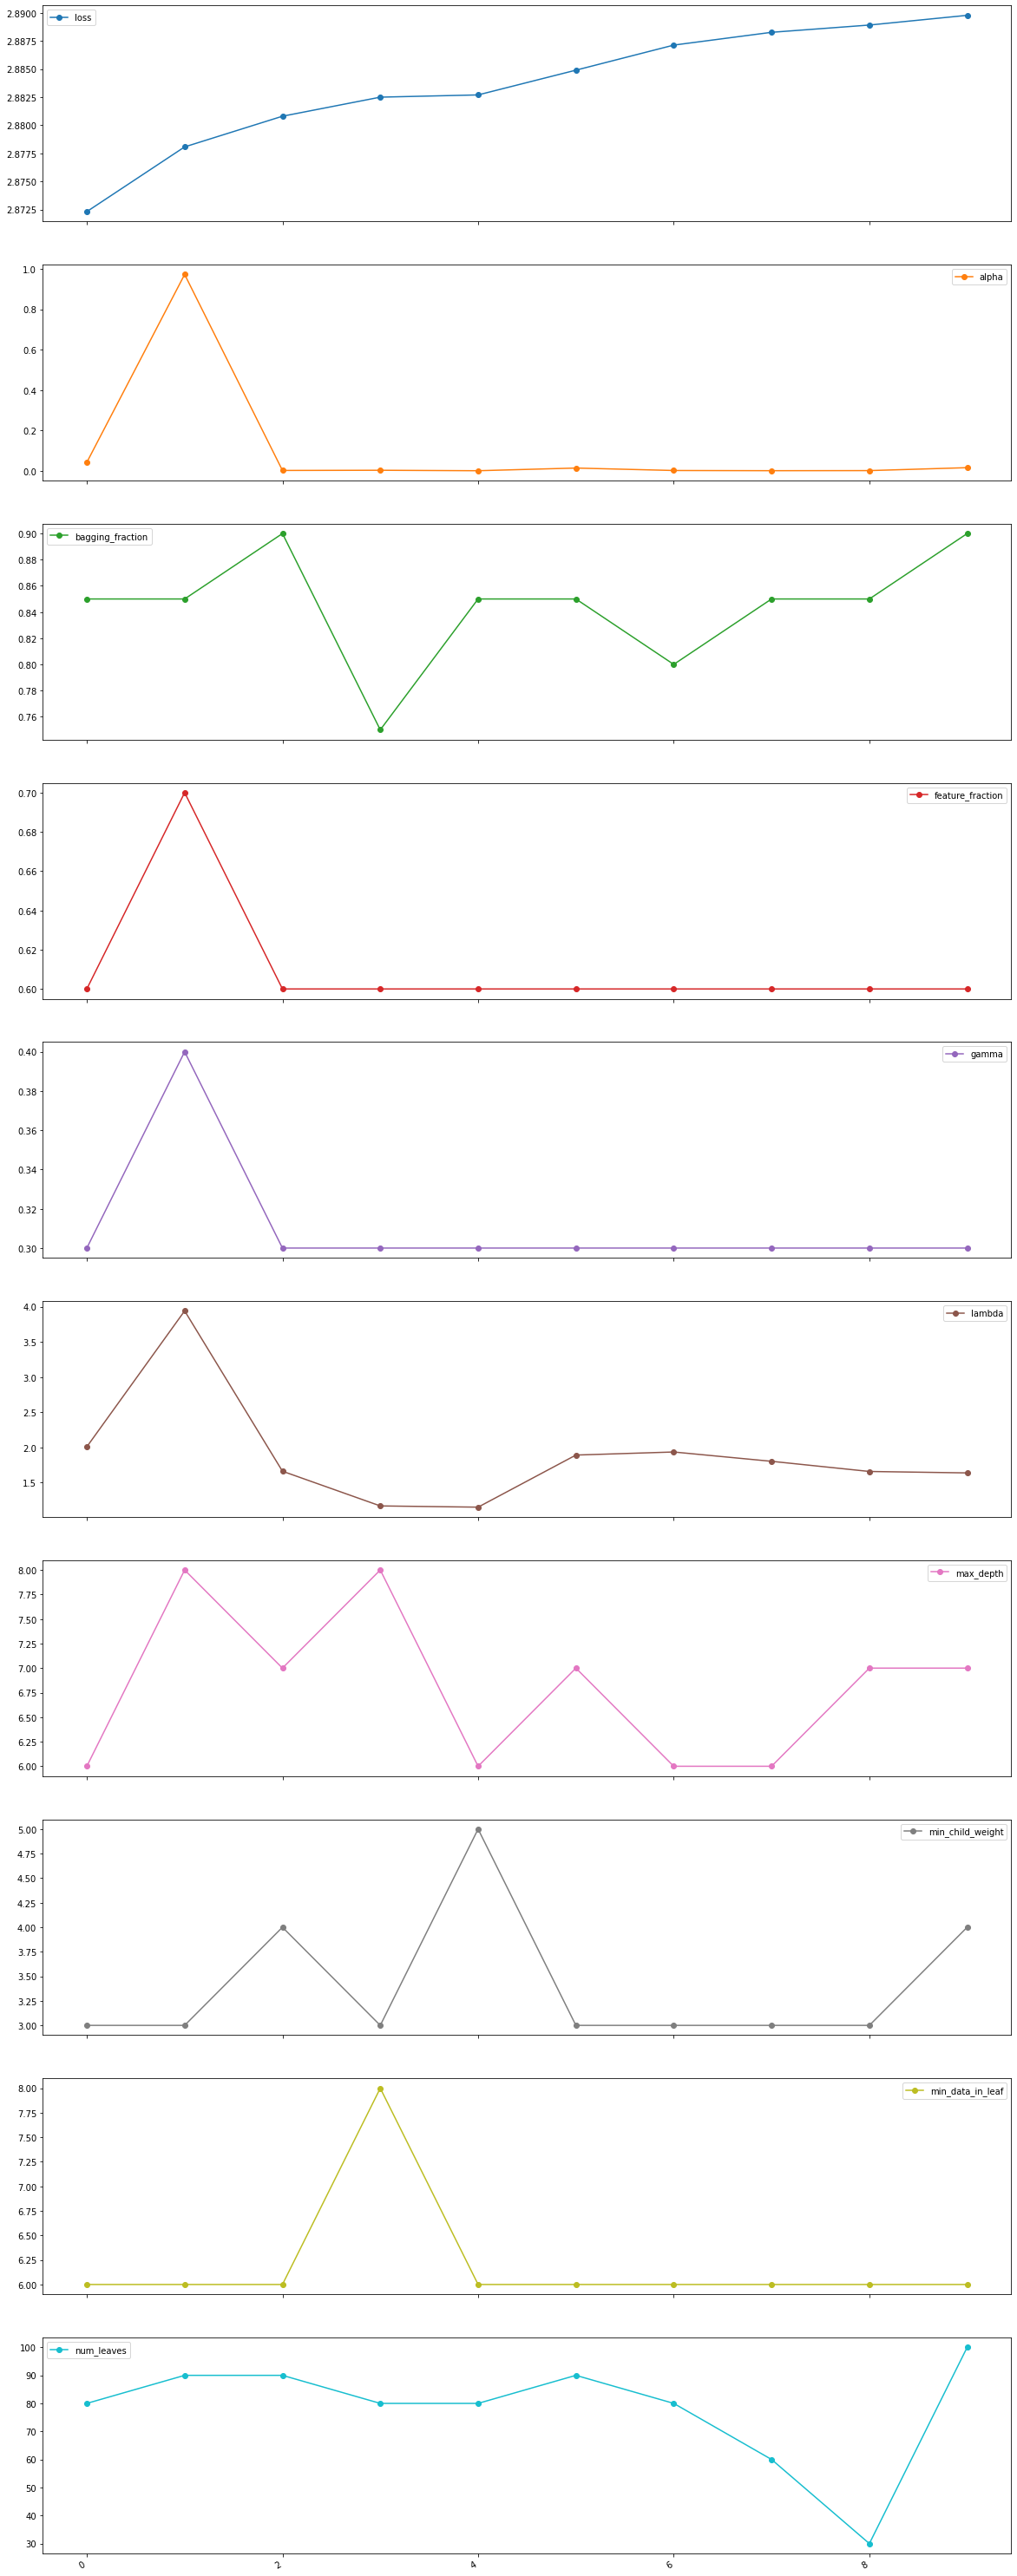

In [266]:
opt_params_df.iloc[:10, :].plot.line(figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True)
plt.show()

In [267]:
# ベストスコアとそのときのパラメータを記録
best_loss = losses[0]
best_params = opt_params[0]

In [268]:
print("best_loss: ")
pprint.pprint(best_loss)
print("\nbest_params: ")
pprint.pprint(best_params)

best_loss: 
2.8723123624478757

best_params: 
{'alpha': 0.04152601060193157,
 'bagging_fraction': 0.8500000000000001,
 'feature_fraction': 0.6000000000000001,
 'gamma': 0.30000000000000004,
 'lambda': 2.009835635550118,
 'max_depth': 6,
 'min_child_weight': 3.0,
 'min_data_in_leaf': 6,
 'num_leaves': 80}


# Create Submission

In [269]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})
importance_list = []

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(train_X, train_y)
submission = pd.concat(
    [submission, pd.Series(best_model.predict(test_treated.drop(['id', 'mpg'], axis=1)), name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,36.192386
1,2,26.385284
2,5,27.136929
3,6,33.026998
4,8,24.209066
...,...,...
495,992,27.802326
496,993,31.500262
497,996,18.095712
498,998,27.097288


### Save files

In [270]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_treated.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_treated.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_lightgbm.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_lightgbm.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '.pickle', 'wb'))
# best train score
pickle.dump(best_loss, open('../logs/logs_test_score' + dt + '.pickle', 'wb'))

# Check Importance

## lgb importance method

In [271]:
importance_df = pd.DataFrame(
    best_model.feature_importances_.tolist(), 
    index=train_X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
display(importance_df)

,importance
acceleration,449
weight,333
horsepower,289
car name,276
displacement,261
model year,246
car_brand,132
origin,77
cylinders,61


## eli5 permutation importance

In [272]:
perm_df = eli5.explain_weights_df(best_model)
perm_df.set_index('feature')

,weight
feature,
cylinders,0.366958
displacement,0.190920
acceleration,0.091796
model_year,0.091060
origin,0.080783
weight,0.063106
horsepower,0.061261
car_name,0.031466
car_brand,0.022651
